In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

import torch
%matplotlib inline

# Load iris data set
Goal: Predict Y = [petal_length, petal_width] = f(X = [sepal_length, sepal_width])

   *  Plot data with seaborn
   *  Remove setosa samples
   *  Recode ‘versicolor’:1, ‘virginica’:2
   *  Scale X and Y
   *  Split data in train/test 50%/50%

In [2]:
iris = sns.load_dataset("iris")

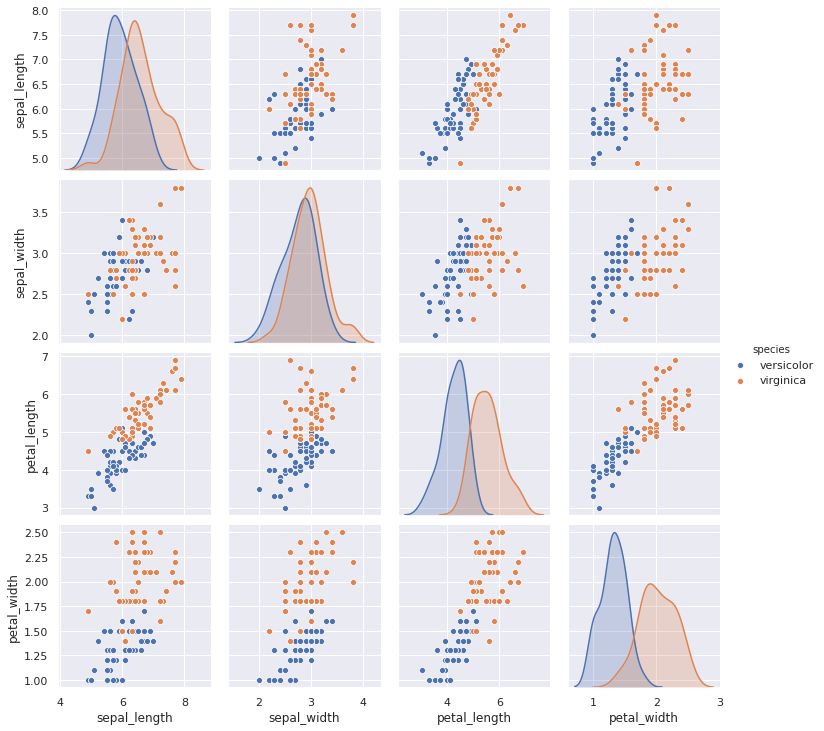

In [3]:
#g = sns.pairplot(iris, hue="species")

df = iris[iris.species != "setosa"]
g = sns.pairplot(df, hue="species")
df['species_n'] = iris.species.map({'versicolor':1, 'virginica':2});

In [4]:
# Y = 'petal_length', 'petal_width'; X = 'sepal_length', 'sepal_width')
X_iris = np.asarray(df.loc[:, ['sepal_length', 'sepal_width']], dtype=np.float32)
Y_iris = np.asarray(df.loc[:, ['petal_length', 'petal_width']], dtype=np.float32)
label_iris = np.asarray(df.species_n, dtype=int)

# Scale

In [5]:
scalerx, scalery = StandardScaler(), StandardScaler()
X_iris = scalerx.fit_transform(X_iris)
Y_iris = StandardScaler().fit_transform(Y_iris)

# Split train test

In [6]:
X_iris_tr, X_iris_val, Y_iris_tr, Y_iris_val, label_iris_tr, label_iris_val = train_test_split(X_iris, Y_iris, label_iris, train_size=0.5,stratify=label_iris)

# Backpropagation with numpy
This implementation uses numpy to manually compute the forward pass, loss, and backward
pass.

In [7]:
# X=X_iris_tr; Y=Y_iris_tr; X_val=X_iris_val; Y_val=Y_iris_val
def two_layer_regression_numpy_train(X, Y, X_val, Y_val, lr, nite):
    # N is batch size; D_in is input dimension;
    # H is hidden dimension; D_out is output dimension.
    # N, D_in, H, D_out = 64, 1000, 100, 10
    N, D_in, H, D_out = X.shape[0], X.shape[1], 100, Y.shape[1]
    W1 = np.random.randn(D_in, H)
    W2 = np.random.randn(H, D_out)
    losses_tr, losses_val = list(), list()
    learning_rate = lr
    for t in range(nite):
        # Forward pass: compute predicted y
        z1 = X.dot(W1)
        h1 = np.maximum(z1, 0)
        Y_pred = h1.dot(W2)
        # Compute and print loss
        loss = np.square(Y_pred - Y).sum()
        # Backprop to compute gradients of w1 and w2 with respect to loss
        grad_y_pred = 2.0 * (Y_pred - Y)
        grad_w2 = h1.T.dot(grad_y_pred)
        grad_h1 = grad_y_pred.dot(W2.T)
        grad_z1 = grad_h1.copy()
        grad_z1[z1 < 0] = 0
        grad_w1 = X.T.dot(grad_z1)
        # Update weights
        W1 -= learning_rate * grad_w1
        W2 -= learning_rate * grad_w2
        # Forward pass for validation set: compute predicted y
        z1 = X_val.dot(W1)
        h1 = np.maximum(z1, 0)
        y_pred_val = h1.dot(W2)
        loss_val = np.square(y_pred_val - Y_val).sum()
        losses_tr.append(loss)
        losses_val.append(loss_val)
        if t % 10 == 0:
            print(t, loss, loss_val)
    return W1, W2, losses_tr, losses_val

0 4236.61908546702 1915.4245347070125
10 242.92437376681343 285.37696823239753
20 95.0783814344703 104.95757736378263
30 65.92894884959145 73.31918293196681
40 58.06299581027249 66.38674001396667


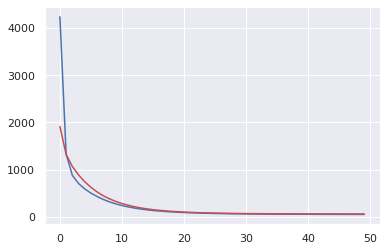

In [8]:
W1, W2, losses_tr, losses_val = two_layer_regression_numpy_train(X=X_iris_tr,
                                                                 Y=Y_iris_tr,
                                                                 X_val=X_iris_val,
                                                                 Y_val=Y_iris_val,
                                                                 lr=1e-4, nite=50);
plt.plot(np.arange(len(losses_tr)), losses_tr, "-b", np.arange(len(losses_val)), losses_val, "-r");

# Backpropagation with PyTorch Tensors

Numpy is a great framework, but it cannot utilize GPUs to accelerate its numerical computations.
For modern deep neural networks, GPUs often provide speedups of 50x or greater,
so unfortunately numpy won’t be enough for modern deep learning. Here we introduce the
most fundamental PyTorch concept: the Tensor. A PyTorch Tensor is conceptually identical to a
numpy array: a Tensor is an n-dimensional array, and PyTorch provides many functions for operating
on these Tensors. Behind the scenes, Tensors can keep track of a computational graph
and gradients, but they’re also useful as a generic tool for scientific computing. Also unlike
numpy, PyTorch Tensors can utilize GPUs to accelerate their numeric computations. To run a
PyTorch Tensor on GPU, you simply need to cast it to a new datatype. Here we use PyTorch
Tensors to fit a two-layer network to random data. Like the numpy example above we need to
manually implement the forward and backward passes through the network:

In [9]:
# X=X_iris_tr; Y=Y_iris_tr; X_val=X_iris_val; Y_val=Y_iris_val
def two_layer_regression_tensor_train(X, Y, X_val, Y_val, lr, nite):
    dtype = torch.float
    device = torch.device("cpu")
    # device = torch.device("cuda:0") # Uncomment this to run on GPU
    # N is batch size; D_in is input dimension;
    # H is hidden dimension; D_out is output dimension.
    N, D_in, H, D_out = X.shape[0], X.shape[1], 100, Y.shape[1]
    # Create random input and output data
    X = torch.from_numpy(X)
    Y = torch.from_numpy(Y)
    X_val = torch.from_numpy(X_val)
    Y_val = torch.from_numpy(Y_val)
    # Randomly initialize weights
    W1 = torch.randn(D_in, H, device=device, dtype=dtype)
    W2 = torch.randn(H, D_out, device=device, dtype=dtype)
    losses_tr, losses_val = list(), list()
    learning_rate = lr
    for t in range(nite):
        # Forward pass: compute predicted y
        z1 = X.mm(W1)
        h1 = z1.clamp(min=0)
        y_pred = h1.mm(W2)
        # Compute and print loss
        loss = (y_pred - Y).pow(2).sum().item()
        # Backprop to compute gradients of w1 and w2 with respect to loss
        grad_y_pred = 2.0 * (y_pred - Y)
        grad_w2 = h1.t().mm(grad_y_pred)
        grad_h1 = grad_y_pred.mm(W2.t())
        grad_z1 = grad_h1.clone()
        grad_z1[z1 < 0] = 0
        grad_w1 = X.t().mm(grad_z1)
        # Update weights using gradient descent
        W1 -= learning_rate * grad_w1
        W2 -= learning_rate * grad_w2
        # Forward pass for validation set: compute predicted y
        z1 = X_val.mm(W1)
        h1 = z1.clamp(min=0)
        y_pred_val = h1.mm(W2)
        loss_val = (y_pred_val - Y_val).pow(2).sum().item()
        losses_tr.append(loss)
        losses_val.append(loss_val)
        if t % 10 == 0:
            print(t, loss, loss_val)
    return W1, W2, losses_tr, losses_val


0 5829.646484375 1243.2720947265625
10 83.14743041992188 84.74931335449219
20 55.4011344909668 62.2729606628418
30 49.67730712890625 57.86414337158203
40 47.37433624267578 56.557884216308594


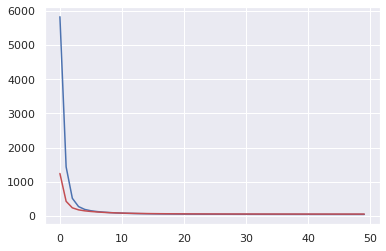

In [10]:
W1, W2, losses_tr, losses_val = two_layer_regression_tensor_train(X=X_iris_tr,
                                                                  Y=Y_iris_tr,
                                                                  X_val=X_iris_val,
                                                                  Y_val=Y_iris_val,
                                                                  lr=1e-4, nite=50)
plt.plot(np.arange(len(losses_tr)), losses_tr, "-b", np.arange(len(losses_val)), losses_val, "-r");

# Backpropagation with PyTorch: Tensors and autograd

A fully-connected ReLU network with one hidden layer and no biases, trained to predict y
from x by minimizing squared Euclidean distance. This implementation computes the forward
pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients.
A PyTorch Tensor represents a node in a computational graph. If x is a Tensor that has x.
requires_grad=True then x.grad is another Tensor holding the gradient of x with respect to
some scalar value.

In [11]:
# X=X_iris_tr; Y=Y_iris_tr; X_val=X_iris_val; Y_val=Y_iris_val
# del X, Y, X_val, Y_val
def two_layer_regression_autograd_train(X, Y, X_val, Y_val, lr, nite):
    dtype = torch.float
    device = torch.device("cpu")
    # device = torch.device("cuda:0") # Uncomment this to run on GPU
    # N is batch size; D_in is input dimension;
    # H is hidden dimension; D_out is output dimension.
    N, D_in, H, D_out = X.shape[0], X.shape[1], 100, Y.shape[1]
    # Setting requires_grad=False indicates that we do not need to compute gradients
    # with respect to these Tensors during the backward pass.
    X = torch.from_numpy(X)
    Y = torch.from_numpy(Y)
    X_val = torch.from_numpy(X_val)
    Y_val = torch.from_numpy(Y_val)
    # Create random Tensors for weights.
    # Setting requires_grad=True indicates that we want to compute gradients with
    # respect to these Tensors during the backward pass.
    W1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
    W2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)
    losses_tr, losses_val = list(), list()
    learning_rate = lr
    for t in range(nite):
        # Forward pass: compute predicted y using operations on Tensors; these
        # are exactly the same operations we used to compute the forward pass using
        # Tensors, but we do not need to keep references to intermediate values since
        # we are not implementing the backward pass by hand.
        y_pred = X.mm(W1).clamp(min=0).mm(W2)
        # Compute and print loss using operations on Tensors.
        # Now loss is a Tensor of shape (1,)
        # loss.item() gets the scalar value held in the loss.
        loss = (y_pred - Y).pow(2).sum()
        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call w1.grad and w2.grad will be Tensors holding the gradient
        # of the loss with respect to w1 and w2 respectively.
        loss.backward()
        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        # An alternative way is to operate on weight.data and weight.grad.data.
        # Recall that tensor.data gives a tensor that shares the storage with
        # tensor, but doesn't track history.
        # You can also use torch.optim.SGD to achieve this.
        with torch.no_grad():
            W1 -= learning_rate * W1.grad
            W2 -= learning_rate * W2.grad
            # Manually zero the gradients after updating weights
            W1.grad.zero_()
            W2.grad.zero_()
            y_pred = X_val.mm(W1).clamp(min=0).mm(W2)
            # Compute and print loss using operations on Tensors.
            # Now loss is a Tensor of shape (1,)
            # loss.item() gets the scalar value held in the loss.
            loss_val = (y_pred - Y).pow(2).sum()
            
        if t % 10 == 0:
            print(t, loss.item(), loss_val.item())
        losses_tr.append(loss.item())
        losses_val.append(loss_val.item())
    return W1, W2, losses_tr, losses_val

0 8424.7685546875 3505.322509765625
10 128.19996643066406 145.8113250732422
20 75.13651275634766 158.90756225585938
30 66.78163146972656 158.93568420410156
40 61.52265167236328 154.63400268554688


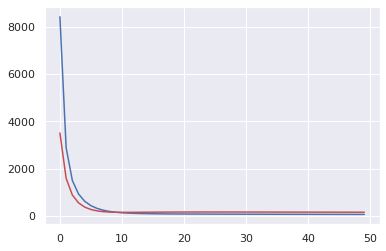

In [12]:
W1, W2, losses_tr, losses_val = two_layer_regression_autograd_train(X=X_iris_tr, Y=Y_iris_tr,
                                                                    X_val=X_iris_val,
                                                                    Y_val=Y_iris_val,
                                                                    lr=1e-4, nite=50)
plt.plot(np.arange(len(losses_tr)), losses_tr, "-b", np.arange(len(losses_val)), losses_val, "-r")

# Backpropagation with PyTorch: Neural Network

This implementation uses the nn package from PyTorch to build the network. PyTorch autograd
makes it easy to define computational graphs and take gradients, but raw autograd can be a bit
too low-level for defining complex neural networks; this is where the nn package can help. The
nn package defines a set of Modules, which you can think of as a neural network layer that has
produces output from input and may have some trainable weights.

In [13]:
# X=X_iris_tr; Y=Y_iris_tr; X_val=X_iris_val; Y_val=Y_iris_val
# del X, Y, X_val, Y_val
def two_layer_regression_nn_train(X, Y, X_val, Y_val, lr, nite):
    # N is batch size; D_in is input dimension;
    # H is hidden dimension; D_out is output dimension.
    N, D_in, H, D_out = X.shape[0], X.shape[1], 100, Y.shape[1]
    X = torch.from_numpy(X)
    Y = torch.from_numpy(Y)
    X_val = torch.from_numpy(X_val)
    Y_val = torch.from_numpy(Y_val)
    # Use the nn package to define our model as a sequence of layers. nn.Sequential
    # is a Module which contains other Modules, and applies them in sequence to
    # produce its output. Each Linear Module computes output from input using a
    # linear function, and holds internal Tensors for its weight and bias.
    model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    )
    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    loss_fn = torch.nn.MSELoss(reduction='sum')
    losses_tr, losses_val = list(), list()
    learning_rate = lr
    for t in range(nite):
        # Forward pass: compute predicted y by passing x to the model. Module objects
        # override the __call__ operator so you can call them like functions. When
        # doing so you pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        y_pred = model(X)
        # Compute and print loss. We pass Tensors containing the predicted and true
        # values of y, and the loss function returns a Tensor containing the
        # loss.
        loss = loss_fn(y_pred, Y)
        # Zero the gradients before running the backward pass.
        model.zero_grad()
        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        # Update the weights using gradient descent. Each parameter is a Tensor, so
        # we can access its gradients like we did before.
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
            y_pred = model(X_val)
            loss_val = (y_pred - Y_val).pow(2).sum()
            if t % 10 == 0:
                print(t, loss.item(), loss_val.item())
        losses_tr.append(loss.item())
        losses_val.append(loss_val.item())
    return model, losses_tr, losses_val

0 69.19059753417969 79.68778991699219
10 52.72893142700195 57.74271774291992
20 47.78563690185547 50.09906768798828
30 45.92768859863281 47.053035736083984
40 45.041412353515625 45.71113967895508


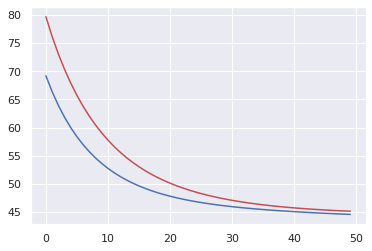

In [14]:
model, losses_tr, losses_val = two_layer_regression_nn_train(X=X_iris_tr, Y=Y_iris_tr,
                                                             X_val=X_iris_val,
                                                             Y_val=Y_iris_val,
                                                             lr=1e-4, nite=50)
plt.plot(np.arange(len(losses_tr)), losses_tr, "-b", np.arange(len(losses_val)), losses_val, "-r");

# Backpropagation with PyTorch optim

This implementation uses the nn package from PyTorch to build the network. Rather than manually
updating the weights of the model as we have been doing, we use the optim package to
254 Chapter 6. Deep Learning
Statistics and Machine Learning in Python, Release 0.3 beta
define an Optimizer that will update the weights for us. The optim package defines many optimization
algorithms that are commonly used for deep learning, including SGD+momentum,
RMSProp, Adam, etc.

In [15]:
# X=X_iris_tr; Y=Y_iris_tr; X_val=X_iris_val; Y_val=Y_iris_val
def two_layer_regression_nn_optim_train(X, Y, X_val, Y_val, lr, nite):
    # N is batch size; D_in is input dimension;
    # H is hidden dimension; D_out is output dimension.
    N, D_in, H, D_out = X.shape[0], X.shape[1], 100, Y.shape[1]
    X = torch.from_numpy(X)
    Y = torch.from_numpy(Y)
    X_val = torch.from_numpy(X_val)
    Y_val = torch.from_numpy(Y_val)
    # Use the nn package to define our model and loss function.
    model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    )
    loss_fn = torch.nn.MSELoss(reduction='sum')
    losses_tr, losses_val = list(), list()
    # Use the optim package to define an Optimizer that will update the weights of
    # the model for us. Here we will use Adam; the optim package contains many other
    # optimization algoriths. The first argument to the Adam constructor tells the
    # optimizer which Tensors it should update.
    learning_rate = lr
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for t in range(nite):
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(X)
        # Compute and print loss.
        loss = loss_fn(y_pred, Y)
        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()
        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
        with torch.no_grad():
            y_pred = model(X_val)
        loss_val = loss_fn(y_pred, Y_val)
        if t % 10 == 0:
            print(t, loss.item(), loss_val.item())
        losses_tr.append(loss.item())
        losses_val.append(loss_val.item())
    return model, losses_tr, losses_val

0 93.46651458740234 110.15082550048828
10 70.53530883789062 80.40726470947266
20 56.2513542175293 61.28858947753906
30 48.874637603759766 51.34159469604492
40 45.51423645019531 47.30419921875


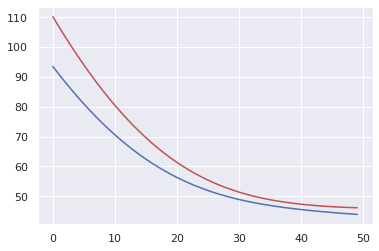

In [16]:
model, losses_tr, losses_val = two_layer_regression_nn_optim_train(X=X_iris_tr, Y=Y_iris_tr,
                                                                   X_val=X_iris_val,
                                                                   Y_val=Y_iris_val,
                                                                   lr=1e-3, nite=50)
plt.plot(np.arange(len(losses_tr)), losses_tr, "-b", np.arange(len(losses_val)), losses_val, "-r");